## Starting my own model

In [1]:
import pandas as pd
import pickle
from gensim.models.phrases import Phrases, Phraser
from collections import defaultdict  # For word frequency

In [2]:
with open("df_clean.csv", "rb") as fp:   # Unpickling
    df_clean = pickle.load(fp)

In [3]:
df_clean = df_clean[~df_clean.clean.str.contains("gt")]

In [4]:
sent = [row.split() for row in df_clean['clean']]

In [5]:
phrases = Phrases(sent, min_count=30)

In [6]:
bigram = Phraser(phrases)
sentences = bigram[sent]

In [ ]:
with open("./data/sentences.txt", "wb") as fp:  # Pickling
    pickle.dump(sentences, fp)

In [ ]:
import multiprocessing

from gensim.models import Word2Vec

In [91]:
cores = multiprocessing.cpu_count() # Count the number of cores in a computer

In [92]:
w2v_model = Word2Vec(min_count=20,
                     window=2,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

In [93]:
w2v_model.build_vocab(a)

### Google Model

In [ ]:
from gensim.models import KeyedVectors
filename = 'GoogleNews-vectors-negative300.bin'
google_model = KeyedVectors.load_word2vec_format(filename, binary=True)

In [ ]:
google_model.most_similar(positive=["man"])

### Fine Tunning

In [ ]:
w2v_model.intersect_word2vec_format('GoogleNews-vectors-negative300.bin', lockf=1.0, binary=True)

In [ ]:
w2v_model.train(sentences[:100000], total_examples=w2v_model.corpus_count, epochs=30)

In [ ]:
w2v_model.wv.most_similar(positive=["incel"])

##### T-SNE  Visualization algorithm (William L. Hamilton paper)

To visualize semantic change for a wordwiin twodimensions we employed the following procedure,which  relies  on  the  t-SNE  embedding  method(Van der Maaten and Hinton, 2008) as a subrou-tine:

* 1.  Find  the  union  of  the  wordwi’sknearestneighbors over all necessary time-points.
* 2.  Compute   the   t-SNE   embedding   of   thesewords on the most recent (i.e.,  the modern)time-point.
* 3.  For  each  of  the  previous  time-points,  holdall  embeddings  fixed,  except  for  the  targetword’s (i.e., the embedding forwi), and op-timize a new t-SNE embedding only for thetarget  word. We  found  that  initializing  theembedding for the target word to be the cen-troid  of  itsk′-nearest  neighbors  in  a  time-point was highly effective.

Thus, in this procedure the background words arealways shown in their “modern” positions, whichmakes sense given that these are the current mean-ings of these words. This approximation is neces-sary, since in reality all words are moving.

#### Aligning historical embeddings

We   use   orthogonal   Procrustes   to   align   thelearned  low-dimensional  embeddings.    DefiningW(t)∈Rd×|V|as the matrix of word embeddingslearned  at  yeart,  we  align  across  time-periodswhile preserving cosine similarities by optimizing:

$R(t)= arg   minQ>Q=I‖QW(t)−W(t+1)‖F $

The  solution  correspondsto  the  best  rotational  alignment  and  can  be  ob-tained  efficiently  using  an  application  of  SVD

##### Pair-wise  similarity  time-series

$ s(t)(wi,wj) =cos-sim(w(t)i,w(t)j) $

In [1]:
from gensim.models import KeyedVectors

wv = KeyedVectors.load("wordvectors.kv", mmap='r')

In [18]:
import pandas as pd
pd.options.mode.chained_assignment = None 
import numpy as np
import re
import nltk

from gensim.models import word2vec

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

In [58]:
def tsne_plot(model, predict_word):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.most_similar([predict_word], topn=30):
        tokens.append(model[word[0]])
        labels.append(word[0])
    
    tokens.append(model[predict_word])
    labels.append(predict_word)
    
    tsne_model = TSNE(perplexity=5, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

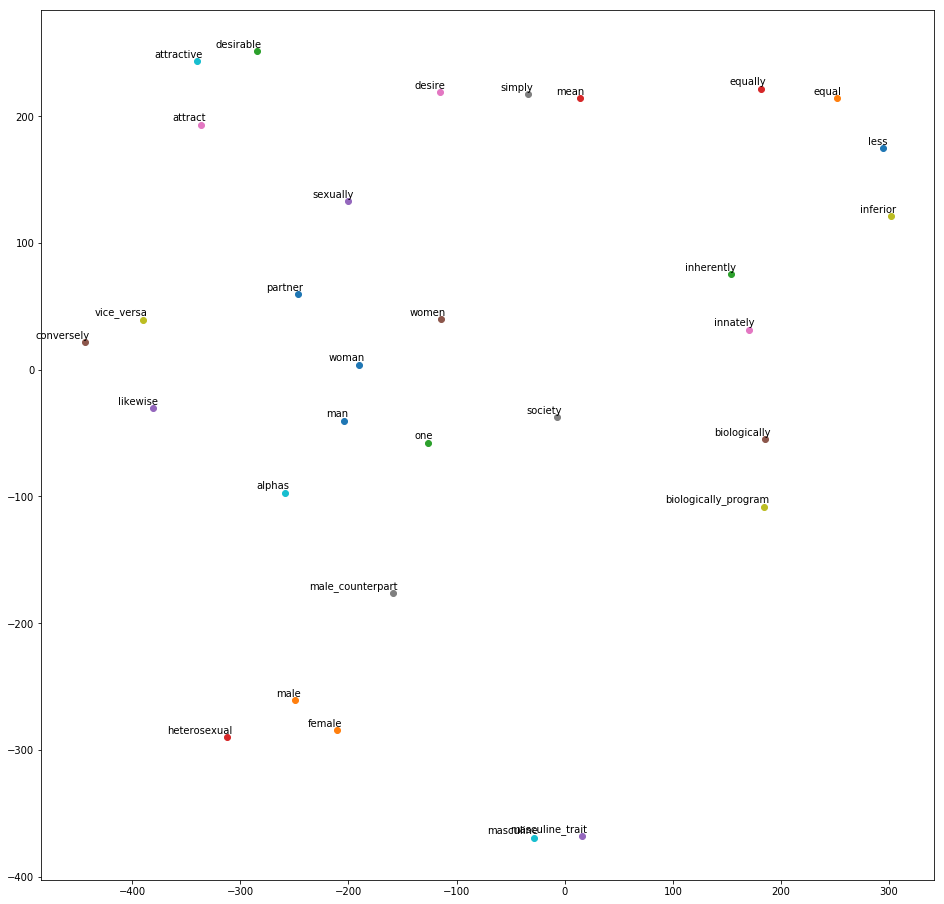

In [59]:
tsne_plot(wv, 'man')